To compare your YOLOv8 model with CNN models built using TensorFlow and Keras, you'll first need to download the dataset from Roboflow in a format that is compatible with TensorFlow/Keras.

Tensorflow Object Detection CSV: This format can be used with the TensorFlow Object Detection API  or by building custom CNN Models as below

-->Prepare the data

-->Define the Model

-->Train the Model

-->Evaluate the Model

In [ ]:
import pandas as pd
import cv2
import numpy as np

def load_dataset(csv_file, image_dir, image_size):
    annotations = pd.read_csv(csv_file)

    images = []
    boxes = []

    for _, row in annotations.iterrows():
        filename = row['filename']
        # Skip rows with invalid filenames
        if not isinstance(filename, str):
            continue

        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is None:  # Check if the image was not loaded properly
            continue

        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize image

        # Assume the CSV columns are named 'xmin', 'ymin', 'xmax', 'ymax'
        xmin = row['xmin'] / img.shape[1]
        ymin = row['ymin'] / img.shape[0]
        xmax = row['xmax'] / img.shape[1]
        ymax = row['ymax'] / img.shape[0]
        box = [xmin, ymin, xmax, ymax]  # Normalize bounding box

        images.append(img)
        boxes.append(box)

    return np.array(images), np.array(boxes)

In [ ]:
import os
os.listdir()

['.config', 'sample_data']

In [7]:
# Example usage
image_size = (224, 224)  # Define your image size
train_images, train_boxes = load_dataset('/content/_annotations.csv',
                                         '/content/drive/MyDrive/Brats.v10i.tensorflow/train', image_size)
valid_images, valid_boxes = load_dataset('/content/drive/MyDrive/Brats.v10i.tensorflow/valid/_annotations.csv',
                                         '/content/drive/MyDrive/Brats.v10i.tensorflow/valid', image_size)
test_images, test_boxes = load_dataset('/content/drive/MyDrive/Brats.v10i.tensorflow/test/_annotations.csv',
                                       '/content/drive/MyDrive/Brats.v10i.tensorflow/test', image_size)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train_images.shape;train_boxes.shape

(3309, 4)

In [9]:
from tensorflow.keras.utils import Sequence
import pandas as pd
import cv2
import numpy as np
import os

class ImageDataGenerator(Sequence):
    def __init__(self, csv_file, image_dir, batch_size=32, image_size=(224, 224)):
        self.df = pd.read_csv(csv_file)
        # Drop rows with NaN in 'filename' column to avoid errors during path joining
        self.df = self.df.dropna(subset=['filename'])
        # Ensure 'filename' is treated as a string
        self.df['filename'] = self.df['filename'].astype(str)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.indices = np.arange(len(self.df))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_boxes = []

        for i in batch_indices:
            row = self.df.iloc[i]
            img_path = os.path.join(self.image_dir, row['filename'])
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, self.image_size)
            img = img / 255.0

            xmin = row['xmin'] / img.shape[1]
            ymin = row['ymin'] / img.shape[0]
            xmax = row['xmax'] / img.shape[1]
            ymax = row['ymax'] / img.shape[0]
            box = [xmin, ymin, xmax, ymax]

            batch_images.append(img)
            batch_boxes.append(box)

        return np.array(batch_images), np.array(batch_boxes)

In [10]:
# Usage example
train_generator = ImageDataGenerator('/content/_annotations.csv', '/content/drive/MyDrive/Brats.v10i.tensorflow/train', batch_size=32, image_size=(224, 224))
valid_generator = ImageDataGenerator('/content/drive/MyDrive/Brats.v10i.tensorflow/valid/_annotations.csv', '/content/drive/MyDrive/Brats.v10i.tensorflow/valid', batch_size=32, image_size=(224, 224))

In [11]:
from tensorflow.keras import layers, models

def create_cnn(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4)  # Output layer for bounding box coordinates
    ])

    model.compile(optimizer='adam', loss='mse')  # Mean Squared Error for bounding box regression
    return model

# Create the model
model = create_cnn((224, 224, 3))

In [12]:
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
104/104 [==============================] - 410s 4s/step - loss: 0.8096 - val_loss: 0.0161
Epoch 2/10
104/104 [==============================] - 398s 4s/step - loss: 0.0125 - val_loss: 0.0121
Epoch 3/10
104/104 [==============================] - 405s 4s/step - loss: 0.0109 - val_loss: 0.0088
Epoch 4/10
104/104 [==============================] - 405s 4s/step - loss: 0.0091 - val_loss: 0.0081
Epoch 5/10
104/104 [==============================] - 402s 4s/step - loss: 0.0091 - val_loss: 0.0081
Epoch 6/10
104/104 [==============================] - 400s 4s/step - loss: 0.0081 - val_loss: 0.0075
Epoch 7/10
104/104 [==============================] - 398s 4s/step - loss: 0.0078 - val_loss: 0.0085
Epoch 8/10
104/104 [==============================] - 405s 4s/step - loss: 0.0072 - val_loss: 0.0066
Epoch 9/10
104/104 [==============================] - 401s 4s/step - loss: 0.0064 - val_loss: 0.0062
Epoch 10/10
104/104 [==============================] - 397s 4s/step - loss: 0.0056 - val_lo

In [13]:
from sklearn.metrics import r2_score

# Predict bounding boxes on the test set
test_images, test_boxes = load_dataset('/content/drive/MyDrive/Brats.v10i.tensorflow/test/_annotations.csv', '/content/drive/MyDrive/Brats.v10i.tensorflow/test', image_size)
predicted_boxes = model.predict(test_images)

# Calculate R-squared value
r_squared = r2_score(test_boxes, predicted_boxes)
print(f'R-squared value: {r_squared}')


5/5 [==============================] - 3s 628ms/step
R-squared value: 0.6644201867679224


In [22]:
!pip install opencv-python
import cv2

In [25]:
def draw_bounding_box(image, box, color=(0, 255, 0), thickness=2):
    """Draws a bounding box on an image.

    Args:
        image: The image to draw on.
        box: The bounding box to draw.
        color: The color of the bounding box.
        thickness: The thickness of the bounding box.

    Returns:
        The image with the bounding box drawn on it.
    """
    # Convert the bounding box to a tuple of integers.
    box = tuple(int(x) for x in bbox)

In [35]:
import tensorflow as tf

1/1 [==============================] - 0s 103ms/step


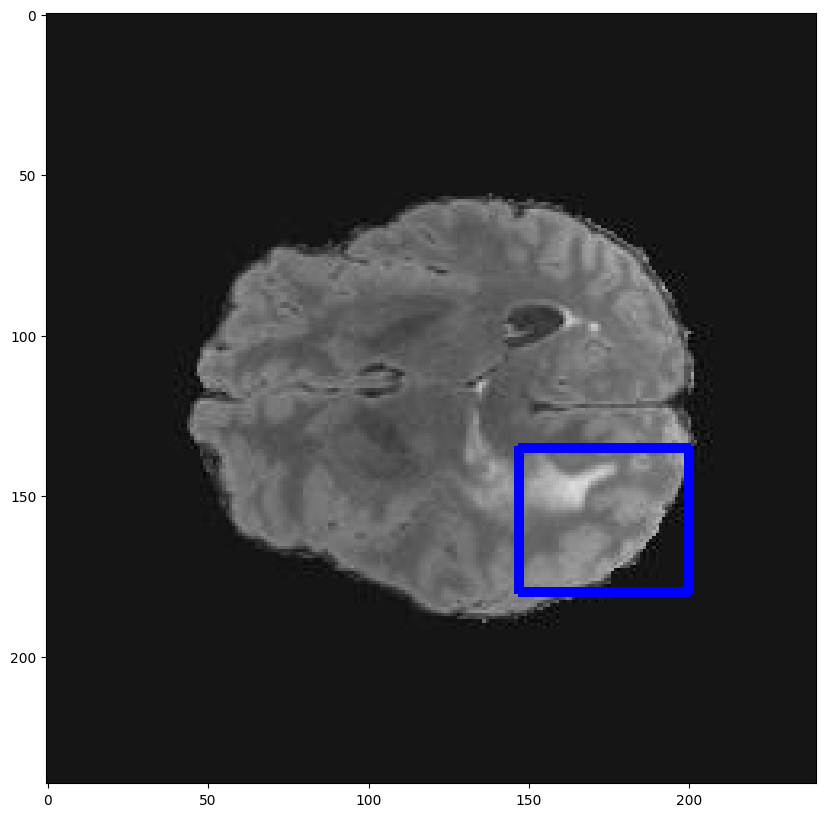

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

def draw_bounding_box(image, box, color=(255, 0, 0), thickness=2):
    # Get image dimensions
    height, width, _ = image.shape

    # Unpack the box coordinates
    xmin, ymin, xmax, ymax = box

    # Convert box coordinates to integer values
    start_point = (int(xmin * width), int(ymin * height))
    end_point = (int(xmax * width), int(ymax * height))

    # Draw the bounding box on the image
    return cv2.rectangle(image, start_point, end_point, color, thickness)


def test_model_on_image(model, img_path, image_size):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, image_size) / 255.0

    # Predict the bounding box
    predicted_box = model.predict(np.array([img_resized]))[0]

    # Draw the bounding box on the original image
    boxed_img = draw_bounding_box(img, predicted_box)

    # Display the image with bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB))
    plt.show()

# Example usage
test_model_on_image(model, '/content/drive/MyDrive/Brats.v10i.tensorflow/test/BraTS2021_00005_10_png.rf.fef3f1b6b3766eccbfbe5f74f6a196e6.jpg', image_size)
